In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import Resize
from sklearn.model_selection import train_test_split
import PIL
import urllib
from tqdm.notebook import tqdm

from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

seed = 42
np.random.seed(seed + 1)
torch.manual_seed(seed)

# Images

In [3]:
image = np.random.rand(64, 64, 3)
image.shape

(64, 64, 3)

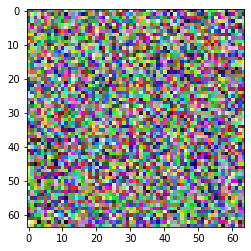

In [4]:
plt.imshow(image)

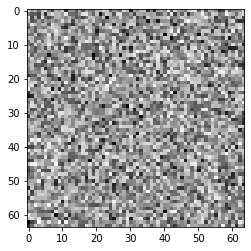

In [5]:
plt.imshow(np.mean(image, axis=2), cmap='Greys')

In [6]:
train_data = torchvision.datasets.MNIST(
    '~/data', 
    train=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)
test_data = torchvision.datasets.MNIST(
    '~/data', 
    train=False,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)
len(train_data), len(test_data)

(60000, 10000)

label: 5


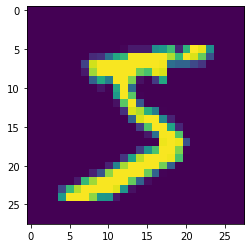

In [7]:
sample = train_data[0]
print(f'label: {sample[1]}')
plt.imshow(sample[0][0].numpy());

In [8]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

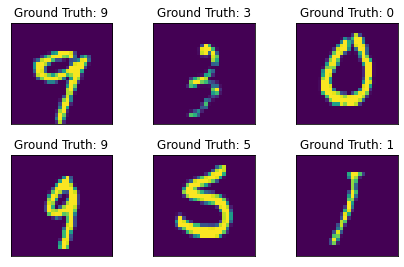

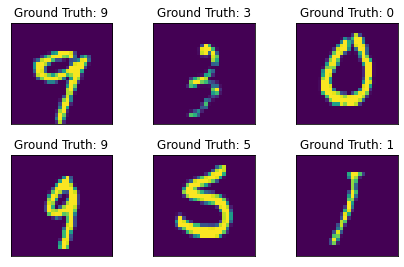

In [9]:
batch = enumerate(test_loader)
idx, (data, labels) = next(batch)

fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(data[i][0].numpy())
    plt.title(f'Ground Truth: {labels[i]}')
    plt.xticks([])
    plt.yticks([])
fig

In [10]:
X_train = train_data.data
y_train = train_data.targets
X_test = test_data.data
y_test = test_data.targets
X_train.shape, X_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

# Convolutions

Size of a convolution of an $n \times n$ image $X$ with an $f\times f$ filter $F$, with stride $s$, padding $p$:
$$\text{size}(X \ast F) = \bigg\lfloor \frac{n + 2p - f}{s} \bigg\rfloor + 1$$

In [11]:
# naive image convolution (cross correlation) with runtime O(n^2*f^2*c)
# note: technically, convolution flips the image vertically and horizontally, then applies this function
def standardize_image(image, channels_last):
    if channels_last and len(image.shape) > 2:
        image = image.transpose(2, 0, 1)
    if len(image.shape) == 2:
        image = image[None, :]
    return image

def convolve(image, kernel, stride=1, padding=False, channels_last=True):
    image = standardize_image(image, channels_last)
    kernel = standardize_image(kernel, channels_last)
    n_rows = image.shape[1]
    n_cols = image.shape[2]
    k_size = len(kernel[0])
    p_size = (k_size - 1) // 2 if padding else 0
    row_reduction = int((n_rows + 2*p_size - k_size) / stride)
    col_reduction = int((n_cols + 2*p_size - k_size) / stride)
    output = np.zeros((row_reduction + 1, col_reduction + 1))
    for i in range(k_size - 1, n_rows - k_size + 1):
        for j in range(k_size - 1, n_cols - k_size + 1):
            base = image[:, i - k_size // 2: i + k_size // 2 + 1, j - k_size // 2: j + k_size // 2 + 1]
            output[i, j] = (base * kernel).sum()
    return output

def min_max_scale(image):
    M, m = image.max(), image.min()
    return (image - m) / (M - m)

In [11]:
image = data[0][0].numpy()
kernel = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
output = convolve(image, kernel, padding=False)
print(image.shape, output.shape)

(28, 28) (26, 26)


In [12]:
image = data[0][0].numpy()
kernel = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
output = convolve(image, kernel, padding=True)
output = min_max_scale(np.abs(output))
print(image.shape, output.shape)

(28, 28) (28, 28)


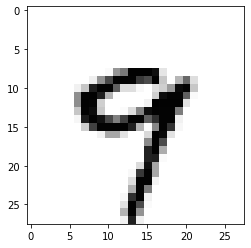

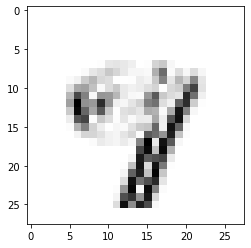

In [13]:
plt.imshow(image, cmap='Greys')
plt.show()
plt.imshow(output, cmap='Greys')
plt.show()

torch.Size([1, 1, 28, 28])


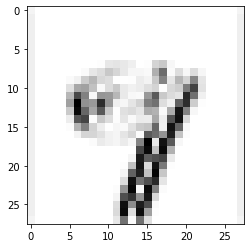

In [14]:
image = data[0][0][None, None, :]
kernel = torch.tensor([[1., 0., -1.], [1., 0., -1.], [1., 0., -1.]])[None, None, :]
output = torch.conv2d(image, kernel, stride=1, padding='same')
print(output.shape)
plt.imshow(min_max_scale(output.abs().numpy()[0][0]), cmap='Greys');

torch.Size([1, 1, 28, 28])


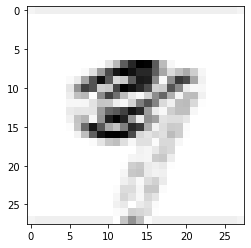

In [15]:
image = data[0][0][None, None, :]
kernel = torch.tensor([[1., 1., 1.], [0., 0., 0.], [-1., -1., -1.]])[None, None, :]
output = torch.conv2d(image, kernel, stride=1, padding='same')
print(output.shape)
plt.imshow(min_max_scale(output.abs().numpy()[0][0]), cmap='Greys');

In [17]:
url = 'https://www.thesprucepets.com/thmb/BJy08SbWKaQsdhkeE16NLNYNZKs=/941x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/GettyImages-1288261359-4016b054680e41d28451f081babd0c45.jpg'
pillow = PIL.Image.open(urllib.request.urlopen(url)).resize((94*2, 63*2))
image = np.array(pillow)
image.shape

(126, 188, 3)

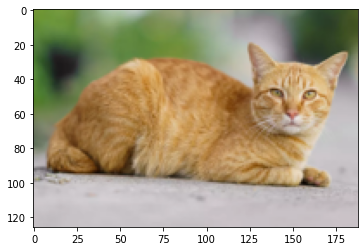

In [18]:
plt.imshow(image)

(126, 188, 3) (126, 188)


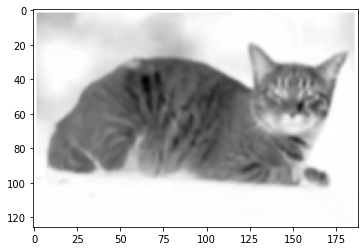

In [19]:
sobel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
kernel = np.array([sobel, sobel, sobel])
output = convolve(image, kernel, padding=True, channels_last=True)
print(image.shape, output.shape)
plt.imshow(min_max_scale(np.abs(output)), cmap='Greys');

torch.Size([1, 1, 126, 188])


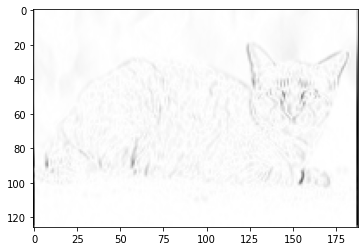

In [20]:
image = torch.tensor(image.transpose(2, 0, 1)[None, :]).float()
kernel = torch.tensor(np.array([sobel, sobel, sobel])).float()[None, :]
output = torch.conv2d(image, kernel, stride=1, padding='same')
print(output.shape)
plt.imshow(min_max_scale(output.abs().numpy()[0][0]), cmap='Greys');

# Convolutional Layers

$$A = \sigma(F \ast X + b)$$


CNN sizes:
- Input size: $a^{[l-1]}$ has size $(h^{[l-1]}, w^{[l-1]}, c^{[l-1]})$
- Output size: $a^{[l]}$ has size $(h^{[l]}, w^{[l]}, c^{[l]})$
- Output height/width in terms of inputs, padding, and stride:
$$h^{[l]} = \bigg\lfloor \frac{h^{[l-1]} + 2p^{[l]} - f^{[l]}}{s^{[l]}} \bigg\rfloor + 1$$
$$w^{[l]} = \bigg\lfloor \frac{w^{[l-1]} + 2p^{[l]} - f^{[l]}}{s^{[l]}} \bigg\rfloor + 1$$
- Filters: $c^{[l]}$ filters of size $(f^{[l]}, f^{[l]}, c^{[l-1]})$ gives $c^{[l]} c^{[l-1]} (f^{[l]})^2$ params for $F^{[l]}$.
- Biases: Biases (one per filter block) of size $(c^{[l]}, 1)$ gives $c^{[l]}$ params for $b^{[l]}$.
- Total params: Filters + biases gives $c^{[l]} (c^{[l-1]} (f^{[l]})^2 + 1)$ total params in layer $l$.

Example: If a layer has 10 filters of size $(3, 3, 3)$, then that layer has $10(3^3+1)=280$ total params.

Note: Pytorch tends to use channels first ordering, so $(c,h,w)$ instead of $(h,w,c)$.

In [21]:
def cnn_layer(input, in_channels, out_channels, kernel_size, padding=True, stride=1, channels_last=False):
    kernels = np.random.randn(out_channels, in_channels, kernel_size, kernel_size)
    bias = np.random.randn(out_channels)
    output = []
    for i in tqdm(range(out_channels)):
        out = convolve(input, kernels[i], padding=padding, stride=stride, channels_last=channels_last)
        out += bias[i]
        output.append(out)
    output = np.array(output)
    return output

output = cnn_layer(min_max_scale(image[0].numpy()), 3, 10, 3)
output.shape

  0%|          | 0/10 [00:00<?, ?it/s]

(10, 126, 188)

In [22]:
def cnn_layer(input, in_channels, out_channels, kernel_size, padding='same', stride=1, channels_last=False):
    kernels = torch.rand(out_channels, in_channels, kernel_size, kernel_size)
    bias = torch.zeros(out_channels)
    output = []
    for i in tqdm(range(out_channels)):
        kernel = kernels[i][None, :]
        out = torch.conv2d(input, kernel, stride=stride, padding=padding)[0][0]
        out += bias[i]
        output.append(out)
    output = torch.stack(output)
    return output[None, :]

output = cnn_layer(min_max_scale(image), 3, 10, 3)
output.shape

  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([1, 10, 126, 188])

In [23]:
cnn = nn.Conv2d(3, 10, 3, padding='same')
output = cnn(image)
output.shape

torch.Size([1, 10, 126, 188])

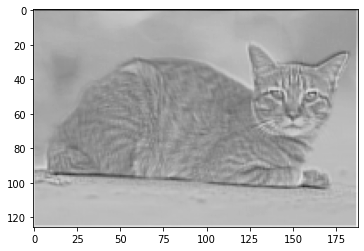

In [24]:
# look at the output for a given out_channel
plt.imshow(output[0][5].detach().numpy(), cmap='Greys')

# Pooling Layers

- Given an $f \times f$ filter, for each channel in the input, slide the filter across the input channel, take the max (or average) of the inputs in the window, and place that in the output. 
- Most commonly, a $2 \times 2$ filter with a stride of 2 is used in pooling, which reduces the input height and width by a factor of 2. 
- The number of channels doesn't change. 
- There are no params to learn in pooling layers. 
- To force the output to be a certain size (so it matches with the next layer), use adaptive pooling (max or average).

In [25]:
pool = nn.MaxPool2d(2, 2)
output = pool(image)
image.shape, output.shape

(torch.Size([1, 3, 126, 188]), torch.Size([1, 3, 63, 94]))

In [26]:
pool = nn.AdaptiveMaxPool2d((100, 100))
output = pool(image)
output.shape

torch.Size([1, 3, 100, 100])

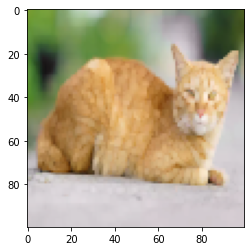

In [27]:
plt.imshow(min_max_scale(output[0].numpy().transpose(1, 2, 0)))

# CNNs

In [6]:
def train_model(train_data, model, opt, loss_fn, num_epochs=1000, plot_loss=True, batch_size=32,
               tensorboard=False, print_loss=True):
    if tensorboard:
        writer = SummaryWriter()
    losses = []
    data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    for epoch in tqdm(range(num_epochs)):
        batch_losses = []
        for X, y in data_loader:
            opt.zero_grad()
            yhat = model(X)
            loss = loss_fn(yhat, y)
            loss.backward()
            opt.step()
            batch_losses.append(float(loss))
        avg_loss = sum(batch_losses) / len(batch_losses)
        losses.append(avg_loss)
        if tensorboard:
            writer.add_scalar("Training Loss", avg_loss, epoch+1)
        if print_loss:
            print(f'epoch={epoch+1} \t\t\t loss={round(avg_loss, 5)}')
    if plot_loss:
        plt.plot(range(len(losses)), losses)
    if tensorboard:
        writer.flush()
        writer.close()
    return model

def get_optimizer(model, optimizer='sgd', lr=0.001, weight_decay=0, momentum=0, betas=(0.9, 0.999), eps=1e-8):
    if optimizer == 'sgd':
        opt = torch.optim.SGD(
            model.parameters(),
            lr=lr, 
            weight_decay=weight_decay, 
            momentum=momentum
        )
    if optimizer == 'adam':
        opt = torch.optim.Adam(
            model.parameters(),
            lr=lr,
            weight_decay=weight_decay,
            betas=betas,
            eps=eps
        )
    return opt

In [58]:
# given a 28x28x1 image, output a 1x10 vector of logits

model = nn.Sequential(
    # nn.ZeroPad2d(padding=2), # reshape to (32, 32) using zero-padding
    
    nn.Conv2d(1, 6, 5), # (1, 28, 28) -> (6, 24, 24)
    # nn.BatchNorm2d(6),
    nn.ReLU(),
    # nn.Dropout2d(0.),
    nn.MaxPool2d(2, 2), # (6, 24, 24) -> (6, 12, 12)
    
    nn.Conv2d(6, 16, 5), # (6, 12, 12) -> (16, 8, 8)
    # nn.BatchNorm2d(16),
    nn.ReLU(),
    # nn.Dropout2d(0.2),
    nn.MaxPool2d(2, 2), # (16, 8, 8) -> (16, 4, 4)
    
    nn.Flatten(), # (16, 4, 4) -> 256
    nn.Linear(256, 120),
    # nn.BatchNorm1d(120),
    nn.ReLU(),
    # nn.Dropout(0.),
    
    
    nn.Linear(120, 84),
    # nn.BatchNorm1d(84),
    nn.ReLU(),
    # nn.Dropout(0.),
    
    nn.Linear(84, 10),
)

model

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=256, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): ReLU()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

In [59]:
x = torch.unsqueeze(train_data.data[:10], dim=1).float()
y = model(x)
x.shape, y.shape

(torch.Size([10, 1, 28, 28]), torch.Size([10, 10]))

In [60]:
%tensorboard --logdir runs

Reusing TensorBoard on port 6007 (pid 50604), started 0:04:14 ago. (Use '!kill 50604' to kill it.)

  0%|          | 0/15 [00:00<?, ?it/s]

epoch=0 			 loss=0.18685
epoch=1 			 loss=0.06282
epoch=2 			 loss=0.04667
epoch=3 			 loss=0.03847
epoch=4 			 loss=0.02982
epoch=5 			 loss=0.02577
epoch=6 			 loss=0.02447
epoch=7 			 loss=0.01944
epoch=8 			 loss=0.01755
epoch=9 			 loss=0.01626
epoch=10 			 loss=0.01412
epoch=11 			 loss=0.01185
epoch=12 			 loss=0.01346
epoch=13 			 loss=0.01212
epoch=14 			 loss=0.01142


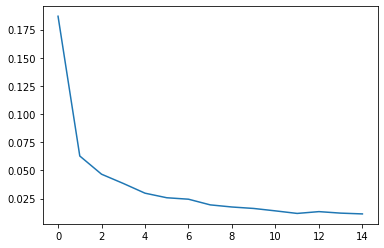

In [61]:
loss_fn = nn.CrossEntropyLoss()
opt = get_optimizer(model, optimizer='adam', lr=0.001, weight_decay=0.)
model = train_model(train_data, model, opt, loss_fn, num_epochs=15, batch_size=32, tensorboard=True)

In [5]:
def eval_model(model, X_train, y_train, X_test, y_test):
    model = model.eval()
    y_pred_train = model(X_train).argmax(dim=1)
    y_pred_test = model(X_test).argmax(dim=1)
    print(f'train accuracy: {(y_pred_train == y_train).sum() / len(y_train)}')
    print(f'test accuracy: {(y_pred_test == y_test).sum() / len(y_test)}')

In [62]:
eval_model(model, train_data.data.unsqueeze(dim=1).float(), train_data.targets, 
           test_data.data.unsqueeze(dim=1).float(), test_data.targets)

train accuracy: 0.993149995803833
test accuracy: 0.9843000173568726


In [176]:
from sklearn.ensemble import RandomForestClassifier

m = RandomForestClassifier(n_jobs=-1)
m.fit(X_train.reshape(60000, 28*28), y_train)

print(m.score(X_train.reshape(60000, 28*28), y_train), m.score(X_test.reshape(10000, 28*28), y_test))

1.0 0.9707


In [4]:
def get_param_shapes(model):
    params = list(model.parameters())
    shapes = [param.detach().numpy().shape for param in params]
    n_params = sum([np.prod(shape) for shape in shapes])
    print(f'param shapes: {shapes}')
    print(f'number of params: {n_params}')

In [41]:
get_param_shapes(model)

param shapes: [(6, 1, 5, 5), (6,), (16, 6, 5, 5), (16,), (120, 256), (120,), (84, 120), (84,), (10, 84), (10,)]
number of params: 44426


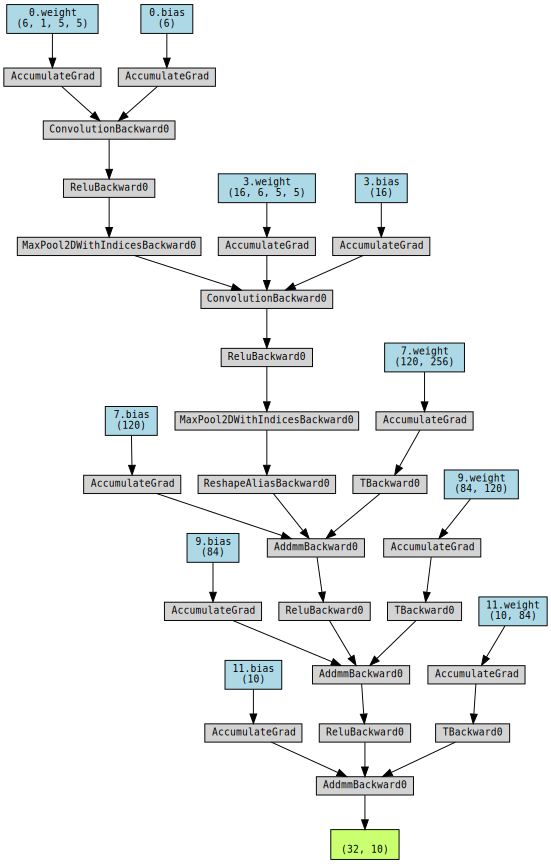

In [42]:
def viz_model(model, dataloader):
    from torchviz import make_dot
    X,y = next(iter(dataloader))
    yhat = model(X)
    plot = make_dot(yhat, params=dict(list(model.named_parameters())), show_attrs=False, show_saved=False)
    return plot
    
plot = viz_model(model, train_loader)
plot

# Common Architectures

## LeNet-5

60k params

In [8]:
model = nn.Sequential(
    Resize((32, 32)), # (1, 28, 28) -> (1, 32, 32)
    
    nn.Conv2d(1, 6, 5), # (1, 32, 32) -> (6, 28, 28)
    nn.Tanh(),
    nn.AvgPool2d(2, 2), # (6, 28, 28) -> (6, 14, 14)
    
    nn.Conv2d(6, 16, 5), # (6, 14, 14) -> (16, 10, 10)
    nn.Tanh(),
    nn.AvgPool2d(2, 2), # (16, 10, 10) -> (16, 5, 5)
    
    nn.Flatten(), # (16, 5, 5) -> 400
    nn.Linear(400, 120),
    nn.Tanh(),
    
    
    nn.Linear(120, 84),
    nn.Tanh(),
    
    nn.Linear(84, 10),
)

model

Sequential(
  (0): Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=None)
  (1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (2): Tanh()
  (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (5): Tanh()
  (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Linear(in_features=400, out_features=120, bias=True)
  (9): Tanh()
  (10): Linear(in_features=120, out_features=84, bias=True)
  (11): Tanh()
  (12): Linear(in_features=84, out_features=10, bias=True)
)

In [9]:
get_param_shapes(model)

param shapes: [(6, 1, 5, 5), (6,), (16, 6, 5, 5), (16,), (120, 400), (120,), (84, 120), (84,), (10, 84), (10,)]
number of params: 61706


  0%|          | 0/15 [00:00<?, ?it/s]

epoch=1 			 loss=0.20105
epoch=2 			 loss=0.06737
epoch=3 			 loss=0.04834
epoch=4 			 loss=0.03824
epoch=5 			 loss=0.03215
epoch=6 			 loss=0.02744
epoch=7 			 loss=0.02272
epoch=8 			 loss=0.02014
epoch=9 			 loss=0.01887
epoch=10 			 loss=0.01633
epoch=11 			 loss=0.01486
epoch=12 			 loss=0.01393
epoch=13 			 loss=0.01377
epoch=14 			 loss=0.0122
epoch=15 			 loss=0.01219


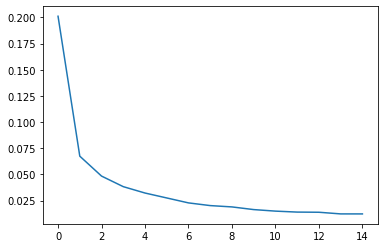

In [73]:
loss_fn = nn.CrossEntropyLoss()
opt = get_optimizer(model, optimizer='adam', lr=0.001, weight_decay=0.)
model = train_model(train_data, model, opt, loss_fn, num_epochs=15, batch_size=32, tensorboard=False)

In [75]:
eval_model(model, X_train.unsqueeze(dim=1).float(), y_train, X_test.unsqueeze(dim=1).float(), y_test)

train accuracy: 0.9533500075340271
test accuracy: 0.9527000188827515


## AlexNet

Number of params: 61M

Notable contributions: First to demonstrate outsized performance for deep learning.

![AlexNet](https://miro.medium.com/max/1400/1*3B8iO-se13vA2QfZ4OBRSw.png)

In [2]:
model = torchvision.models.alexnet(pretrained=False)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [7]:
get_param_shapes(model)

param shapes: [(64, 3, 11, 11), (64,), (192, 64, 5, 5), (192,), (384, 192, 3, 3), (384,), (256, 384, 3, 3), (256,), (256, 256, 3, 3), (256,), (4096, 9216), (4096,), (4096, 4096), (4096,), (1000, 4096), (1000,)]
number of params: 61100840


## VGG-16

Number of params: 138M

Notable contributions: First to use simplified blocks in succession. Always 3x3 kernels, stride 1. Always pooling with 2x2 kernels, stride 2. Batch norm came as an improvement.

![Vgg16](https://miro.medium.com/max/940/1*3-TqqkRQ4rWLOMX-gvkYwA.png)

In [14]:
model = torchvision.models.vgg16(pretrained=False)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [15]:
get_param_shapes(model)

param shapes: [(64, 3, 3, 3), (64,), (64, 64, 3, 3), (64,), (128, 64, 3, 3), (128,), (128, 128, 3, 3), (128,), (256, 128, 3, 3), (256,), (256, 256, 3, 3), (256,), (256, 256, 3, 3), (256,), (512, 256, 3, 3), (512,), (512, 512, 3, 3), (512,), (512, 512, 3, 3), (512,), (512, 512, 3, 3), (512,), (512, 512, 3, 3), (512,), (512, 512, 3, 3), (512,), (4096, 25088), (4096,), (4096, 4096), (4096,), (1000, 4096), (1000,)]
number of params: 138357544


## Resnet

Number of params:
- Resnet-18: 11.7M
- Resnet-34: 21.8M
- Resnet-50: 25.6M
- Resnet-101: 44.5M
- Resnet-152: 60.2M

Residual Blocks:

Notable Contributions: First to use skip connections to allow learning the identity function, allows much deeper networks (100+ layers) since skip connections help prevent gradient explosion/vanishing in deeper layers.


![Resnet18](https://www.researchgate.net/publication/336642248/figure/fig1/AS:839151377203201@1577080687133/Original-ResNet-18-Architecture.png)

In [ ]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding='same', bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same', bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.Relu(inplace=True)
        self.downsample = downsample
        self.stride = stride
        if self.downsample:
            self.convr = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, bias=False)
            self.bnr = nn.BatchNorm2d(out_channels)
    
    def forward(self, x):
        r = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.downsample:
            r = self.convr(r)
            r = self.bnr(r)
        x += r
        x = self.relu(x)
        return x
    
def ResNet(nn.Module):
    def __init__(self, in_channels, layers, n_classes):
        super().__init__()
        assert len(layers) == 5
        self.conv1 = nn.Conv2d(in_channels, layers[0], kernel_size=7, stride=2, padding='same', bias=False)
        self.bn1 = nn.BatchNorm2d(layers[0])
        self.pool1 = nn.MaxPool2d(layers[0])
        self.layer1 = self.make_layer(layers[0], layers[1])
        self.layer2 = self.make_layer(layers[1], layers[2])
        self.layer3 = self.make_layer(layers[2], layers[3])
        self.layer4 = self.make_layer(layers[3], layers[4])
        self.pool2 = nn.AdaptiveAvgPool2d(output_size=1)
        self.linear = nn.Linear(layers[4], n_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.pool1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.pool2(x)
        x = self.linear(x)
        return x
    
    def make_layer(self, in_channels, out_channels):
        downsample = (in_channels == out_channels)
        layer = nn.sequential(
            ResNetBlock(in_channels, out_channels),
            ResNetBlock(out_channels, out_channels, downsample)
        )
        return layer

layers = [64, 64, 128, 256, 512]
model = ResNet(1, layers, 10)

In [12]:
model = torchvision.models.resnet18(pretrained=False)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
get_param_shapes(model)

param shapes: [(64, 3, 7, 7), (64,), (64,), (64, 64, 3, 3), (64,), (64,), (64, 64, 3, 3), (64,), (64,), (64, 64, 3, 3), (64,), (64,), (64, 64, 3, 3), (64,), (64,), (128, 64, 3, 3), (128,), (128,), (128, 128, 3, 3), (128,), (128,), (128, 64, 1, 1), (128,), (128,), (128, 128, 3, 3), (128,), (128,), (128, 128, 3, 3), (128,), (128,), (256, 128, 3, 3), (256,), (256,), (256, 256, 3, 3), (256,), (256,), (256, 128, 1, 1), (256,), (256,), (256, 256, 3, 3), (256,), (256,), (256, 256, 3, 3), (256,), (256,), (512, 256, 3, 3), (512,), (512,), (512, 512, 3, 3), (512,), (512,), (512, 256, 1, 1), (512,), (512,), (512, 512, 3, 3), (512,), (512,), (512, 512, 3, 3), (512,), (512,), (1000, 512), (1000,)]
number of params: 11689512


## Inception Networks

Number of params (v3): 27.2M

Notable Contributions: Uses filters of different sizes in the same layer and stacks them up (e.g. 1x1, 3x3, 5x5 with same padding). This allows the network to "decide" how fine grained features it wants to extract in any given layer. Use "bottleneck layers", which reduce computational cost of 5x5 convs by first using a 1x1 conv to reduce the input channels (e.g. by a factor of 10). Cites the "we need to go deeper" meme based on the Inception movie.

Note: 1x1 conv layers are useful for changing `in_channel` to `out_channel` while preserving input height and width. Each pixel gets multiplied by a weight value and pass through an activation, for each `out_channel`.

![Inception](https://cdn.analyticsvidhya.com/wp-content/uploads/2018/10/googlenet.png)

In [22]:
model = torchvision.models.inception_v3(pretrained=False)
get_param_shapes(model)

param shapes: [(32, 3, 3, 3), (32,), (32,), (32, 32, 3, 3), (32,), (32,), (64, 32, 3, 3), (64,), (64,), (80, 64, 1, 1), (80,), (80,), (192, 80, 3, 3), (192,), (192,), (64, 192, 1, 1), (64,), (64,), (48, 192, 1, 1), (48,), (48,), (64, 48, 5, 5), (64,), (64,), (64, 192, 1, 1), (64,), (64,), (96, 64, 3, 3), (96,), (96,), (96, 96, 3, 3), (96,), (96,), (32, 192, 1, 1), (32,), (32,), (64, 256, 1, 1), (64,), (64,), (48, 256, 1, 1), (48,), (48,), (64, 48, 5, 5), (64,), (64,), (64, 256, 1, 1), (64,), (64,), (96, 64, 3, 3), (96,), (96,), (96, 96, 3, 3), (96,), (96,), (64, 256, 1, 1), (64,), (64,), (64, 288, 1, 1), (64,), (64,), (48, 288, 1, 1), (48,), (48,), (64, 48, 5, 5), (64,), (64,), (64, 288, 1, 1), (64,), (64,), (96, 64, 3, 3), (96,), (96,), (96, 96, 3, 3), (96,), (96,), (64, 288, 1, 1), (64,), (64,), (384, 288, 3, 3), (384,), (384,), (64, 288, 1, 1), (64,), (64,), (96, 64, 3, 3), (96,), (96,), (96, 96, 3, 3), (96,), (96,), (192, 768, 1, 1), (192,), (192,), (128, 768, 1, 1), (128,), (128,)

## MobileNet

Number of params: 2.5M - 5.5M (see below)

Computational cost of convolutions $(h, w, c) \ast (k, k, c') \rightarrow (h', w', c')$:
- Standard: $(k k c') \times (h' w' c') = k^2c'^2h'w'$
- Depthwise Separable:
    - Depthwise convolution: $(k k) \times (h' w' c) = k^2 h' w' c$
    - Separable convolution: $(1 1 c') \times (h' w' c) = c h' w' c'$
    - Total: $(k^2 h' w' c) + (c h' w' c') = c h' w' (k^2 + c')$
- Cost Savings: $r = \frac{c h' w' (k^2 + c')}{k^2c'^2h'w'} \sim \frac{1}{c'} + \frac{1}{k^2} \approx \frac{1}{k^2}$ (e.g. $k=3$ means cost savings is $1/9 \approx 1/10$, or 10x cheaper)

Notable Contributions: Introduced depthwise separable convolutions, which enable convolutions to be done with far fewer FLOPs. In v2, residual bottleneck blocks are used with expand-depthwise-reduce layers to create lots of weights and squeeze them back down to the input size to add in the residual.

![MobileNetv2](https://machinethink.net/images/mobilenet-v2/ExpandProject@2x.png)

In [2]:
class DepthwiseSeparableConv2d(nn.Module):
    def __init__(self, c_in, c_out):
        super.__init__()
        self.depthwise = nn.Conv2d(c_in, c_in, kernel_size=3, padding=1, groups=c_in)
        self.pointwise = nn.Conv2d(c_in, c_out, kernel_size=1)
    
    def forward(self, x):
        x = self.depthwise(x) 
        out = self.pointwise(x) 
        return x

class ResidualBottleNeck(nn.Module):
    def __init__(self, c_in, c_mid):
        super.__init__()
        self.expand = nn.Conv2d(c_in, c_mid, kernel_size=1)
        self.depthwise = nn.Conv2d(c_mid, c_mid, kernel_size=3, padding=1, groups=c_mid)
        self.projection = nn.Conv2d(c_mid, c_in, kernel_size=1)
            
    def forward(self, x):
        r = x
        x = self.expand(x)
        x = self.depthwise(x)
        x = self.projection(x)
        return r + x

In [3]:
def get_n_params(model):
    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return n_params

In [33]:
model = torchvision.models.mobilenet_v2(pretrained=False)
n_params = get_n_params(model)
print(f'v2: n_params={n_params}')

model = torchvision.models.mobilenet_v3_small(pretrained=False)
n_params = get_n_params(model)
print(f'v3_small: n_params={n_params}')

model = torchvision.models.mobilenet_v3_large(pretrained=False)
n_params = get_n_params(model)
print(f'v3_large: n_params={n_params}')

v2: n_params=3504872
v3_small: n_params=2542856
v3_large: n_params=5483032


## EfficientNet

Number of params: 5M - 66M (see below)

Notable Contributions: Allows the compound scaling of model sizes in an efficient way to match device limitations (using resolution, network depth, and layer widths scaled by fixed ratios). Uses mobilenet residual bottlenecks (called MBConvs) as building blocks.

![EfficientNet](https://www.researchgate.net/publication/348470984/figure/fig2/AS:979961129209859@1610652348348/The-EffecientNet-B0-general-architecture.png)

![Scaling](https://amaarora.github.io/images/effnet_moment.png)

In [27]:
for i in range(8):
    name = 'torchvision.models.efficientnet_b' + str(i)
    model = eval(name)(pretrained=False)
    n_params = get_n_params(model)
    print(f'b{i}: n_params={n_params}')

b0: n_params=5288548
b1: n_params=7794184
b2: n_params=9109994
b3: n_params=12233232
b4: n_params=19341616
b5: n_params=30389784
b6: n_params=43040704
b7: n_params=66347960
